In [3]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("DynamicalSystems")
Pkg.add("Distributions")
using LinearAlgebra, Plots
import ForwardDiff as FD
import MeshCat as mc 
import Convex as cvx 
import ECOS
using JLD2
using Test
using Random
using ProgressMeter
include(joinpath(@__DIR__,"utils/cartpole_animation.jl"))
include(joinpath(@__DIR__,"utils/basin_of_attraction.jl"))
using GaussianFilters, LinearAlgebra, Distributions
include(joinpath(@__DIR__,"utils/rendezvous.jl"))

  Activating environment at `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Manifest.toml`


thruster_model (generic function with 1 method)

In [71]:
# utilities for converting to and from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

function dynamics(params::NamedTuple, x::Vector, u)
    mu = 3.986004418e14 # standard gravitational parameter
    a = 6971100.0       # semi-major axis of ISS
    n = sqrt(mu/a^3)    # mean motion

    # continuous time dynamics ẋ = Ax + Bu
    A = [0     0  0    1   0   0; 
         0     0  0    0   1   0;
         0     0  0    0   0   1;
         3*n^2 0  0    0   2*n 0;
         0     0  0   -2*n 0   0;
         0     0 -n^2  0   0   0]
         
    B = Matrix([zeros(3,3);0.1*I(3)])

    # TODO: convert to discrete time X_{k+1} = Ad*x_k + Bd*u_k
    nx, nu = size(B)
    dt_mat = exp([A B;zeros(nu, nx+nu)]*dt)

    Ad = dt_mat[1:nx, 1:nx]
    Bd = dt_mat[1:nx, (nx+1):end]

    return Ad, Bd

end

function create_dynamics(dt::Real)::Tuple{Matrix,Matrix}
    mu = 3.986004418e14 # standard gravitational parameter
    a = 6971100.0       # semi-major axis of ISS
    n = sqrt(mu/a^3)    # mean motion

    # continuous time dynamics ẋ = Ax + Bu
    A = [0     0  0    1   0   0; 
         0     0  0    0   1   0;
         0     0  0    0   0   1;
         3*n^2 0  0    0   2*n 0;
         0     0  0   -2*n 0   0;
         0     0 -n^2  0   0   0]
         
    B = Matrix([zeros(3,3);0.1*I(3)])

    # TODO: convert to discrete time X_{k+1} = Ad*x_k + Bd*u_k
    nx, nu = size(B)
    dt_mat = exp([A B;zeros(nu, nx+nu)]*dt)

    Ad = dt_mat[1:nx, 1:nx]
    Bd = dt_mat[1:nx, (nx+1):end]

    return Ad, Bd
end

function process_model(x, u, dt::Real)
    mu = 3.986004418e14 # standard gravitational parameter
    a = 6971100.0       # semi-major axis of ISS
    n = sqrt(mu/a^3)    # mean motion

    # continuous time dynamics ẋ = Ax + Bu
    A = [0     0  0    1   0   0; 
         0     0  0    0   1   0;
         0     0  0    0   0   1;
         3*n^2 0  0    0   2*n 0;
         0     0  0   -2*n 0   0;
         0     0 -n^2  0   0   0]
         
    B = Matrix([zeros(3,3);0.1*I(3)])

    # TODO: convert to discrete time X_{k+1} = Ad*x_k + Bd*u_k
    # nx, nu = size(B)
    # dt_mat = exp([A B;zeros(nu, nx+nu)]*dt)

    # Ad = dt_mat[1:nx, 1:nx]
    # Bd = dt_mat[1:nx, (nx+1):end]

    return A * x + B * u
end

function measurement_model(x)
    # Change c for number of state to observe !!
    C = [1 0 0 0 0 0;
    0 1 0 0 0 0;
    0 0 1 0 0 0]
    return C * x
end

function simulate_gt(x0, num_steps, u)
    x = x0  # Initial state 
    gt = []
    for i in 1:num_steps
        y = measurement_model(x)
        push!(gt, y)
        x = process_model(x, u[i,:], 1.0) 
    end
    return gt
end

# Generate noisy measurements
function simulate_damper_system(x0, num_steps, u, measurement_noise_matrix)
    x = x0  # Initial state 
    measurements = []
    for i in 1:num_steps
        y = measurement_model(x) + measurement_noise_matrix #[measurement_noise*randn()]  
        push!(measurements, y)
        x = process_model(x, u[i,:], 1.0) #+ [measurement_noise*randn(), measurement_noise*randn()]  # Add some process noise
    end
    return measurements
end

function rk4(params::NamedTuple, x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

function ihlqr(A::Matrix,       # vector of A matrices 
               B::Matrix,       # vector of B matrices
               Q::Matrix,       # cost matrix Q 
               R::Matrix;       # cost matrix R 
               max_iter = 1000, # max iterations for Ricatti 
               tol = 1e-5       # convergence tolerance
               )::Tuple{Matrix, Matrix} # return two matrices 
        
    # get size of x and u from B 
    nx, nu = size(B)
        
    # initialize S with Q
    P = deepcopy(Q)
    
    # Ricatti 
    for ricatti_iter = 1:max_iter 
        K = (R + B' * P * B) \ (B' * P * A)
        P_new = Q + K' * R * K + (A - B * K)' * P * (A - B * K)

        if norm(P_new - P) <= tol
            return P_new, K
        end
        
        # update P for the next iteration
        P = P_new
    end
    error("ihlqr did not converge")
end

function fhlqr(A::Matrix, # A matrix 
    B::Matrix, # B matrix 
    Q::Matrix, # cost weight 
    R::Matrix, # cost weight 
    Qf::Matrix,# term cost weight 
    N::Int64   # horizon size 
    )::Tuple{Vector{Matrix{Float64}}, Vector{Matrix{Float64}}} # return two matrices 

# check sizes of everything 
nx,nu = size(B)
@assert size(A) == (nx, nx)
@assert size(Q) == (nx, nx)
@assert size(R) == (nu, nu)
@assert size(Qf) == (nx, nx)

# instantiate S and K 
P = [zeros(nx,nx) for i = 1:N]
K = [zeros(nu,nx) for i = 1:N-1]


# initialize S[N] with Qf 
P[N] = deepcopy(Qf)

# Ricatti 
for k = N-1:-1:1
K[k] .= (R + B'*P[k+1]*B)\(B'*P[k+1]*A)
P[k] .= Q + A'*P[k+1]*(A-B*K[k])
end

return P, K 
end

fhlqr (generic function with 1 method)

In [84]:
function RHE(A::Matrix, # discrete dynamics A 
    B::Matrix, # discrete dynamics B 
    z, # measurement
    x0::Vector, # initial condition  
    N::Int64, # length of trajectory 
    )::Tuple{Vector{Vector{Float64}}, Vector{Vector{Float64}}} # return Xcvx,Ucvx

    # get our sizes for state and control
    nx,nu = size(B)

    @assert size(A) == (nx, nx)
    @assert length(x0) == nx  

    # LQR cost
    #Q = diagm(ones(nx))
    Q = diagm(ones(nu))
    R = diagm(ones(nu))

    # variables we are solving for
    X = cvx.Variable(nx,N)
    U = cvx.Variable(nu,N-1)

    # implement cost
    obj = 0 
    for k = 1:(N-1)
        x_k = X[:,k]
        u_k = U[:,k]
        obj += 1/2*cvx.quadform(z[k] - measurement_model(x_k),Q) #+ 1/2*cvx.quadform(u_k,R)
    end

    obj += 1/2*cvx.quadform(z[N] - measurement_model(X[:,N]),Q)
    # create problem with objective
    prob = cvx.minimize(obj)
    prob.constraints += (X[:,1] == x0)
    
    for k = 1:(N-1)
        prob.constraints += (X[:,k+1] == A*X[:,k]+B*U[:,k])
    end
    # prob.constraints += (X[:,N] == xg)

    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    X = X.value
    U = U.value

    Xcvx = vec_from_mat(X)
    Ucvx = vec_from_mat(U)

    return Xcvx, Ucvx
end

RHE (generic function with 4 methods)

## RHE for space station docking

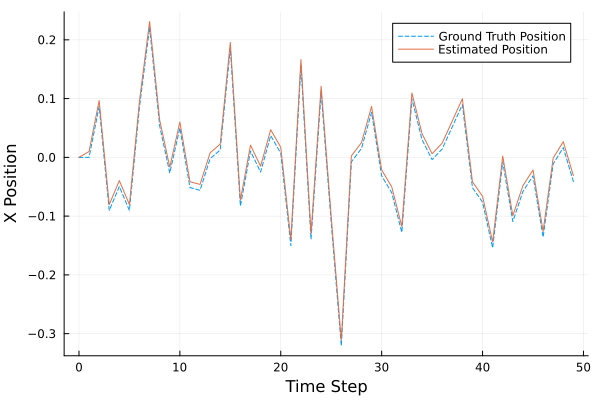

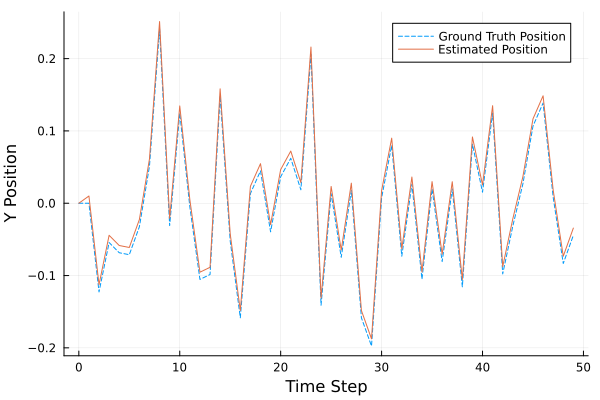

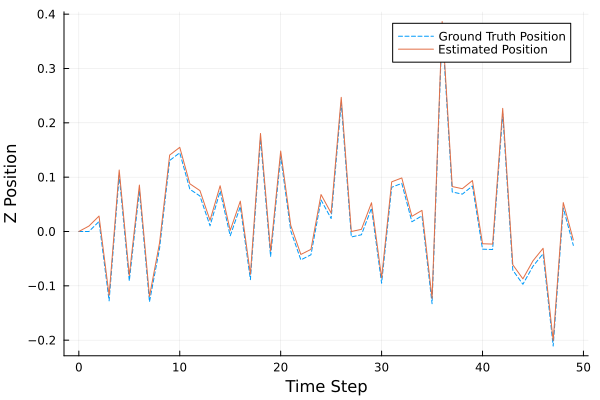

Test Summary:  |
convex trajopt | No tests


Test.DefaultTestSet("convex trajopt", Any[], 0, false, false)

In [93]:
@testset "convex trajopt" begin 
    Random.seed!(1234)
    # create our discrete time model 
    dt = 1.0
    A,B = create_dynamics(dt)

    # get our sizes for state and control
    nx,nu = size(B)

    # initial and goal states
    # x0 = [-2;-4;2;0;0;.0]
    x0 = zeros(nx)
    # problem size and reference trajectory 
    N = 50
    t_vec = 0:dt:((N-1)*dt)
    u = [randn(N) randn(N) randn(N)] # Random control input
    observ_state_num = 3
    measurement_noise_matrix = fill(0.01, (observ_state_num, 1))

    gt = simulate_gt(x0, N, u)
    measurements = simulate_damper_system(x0, N, u, measurement_noise_matrix)
    
    # solve Receding Horiozon Estimator  
    X_cvx, U_cvx = RHE(A,B,measurements, x0,N)
    
    X_sim = [zeros(nx) for i = 1:N]
    X_sim[1] = x0 
    for i = 1:N-1 
        X_sim[i+1] = A*X_sim[i] + B*U_cvx[i]
    end

    
    # -------------plotting---------------------------
    
    Xm = mat_from_vec(X_sim)
    Um = mat_from_vec(U_cvx)
    plots = []
    axis = ['X', 'Y', 'Z']
    for i in 1:length(gt[1])
        p = plot(t_vec, [m[i] for m in gt], label="Ground Truth Position", xlabel="Time Step", ylabel="$(axis[i]) Position", linestyle=:dash)
        plot!(t_vec, Xm[i,:], label="Estimated Position", linestyle=:solid)
        push!(plots, p)  # Collect each plot in an array
    end
    
    for p in plots
        display(p)
    end
    
    # display(plot(t_vec,Xm[1:3,:]',title = "Positions",
    #              xlabel = "time (s)", ylabel = "position (m)",
    #              label = ["x" "y" "z"]))
    
    # display(plot(t_vec,Xm[4:6,:]',title = "Velocities",
    #         xlabel = "time (s)", ylabel = "velocity (m/s)",
    #              label = ["x" "y" "z"]))
    # display(plot(t_vec[1:end-1],Um',title = "Control",
    #         xlabel = "time (s)", ylabel = "thrust (N)",
    #              label = ["x" "y" "z"]))


end